In [1]:
#default_exp train

In [1]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *

Loading imports


In [2]:
torch.cuda.set_device(3)

In [4]:
#export
def get_pil_fn(p):
    def _f(fn): return PILCTScan.create(p/f'{fn}.jpg')
    return _f

In [5]:
#export
def fn2label(fn): return Meta.df_comb.loc[fn][htypes].values.astype(np.float32)

In [6]:
#export
def get_data_gen(fns, bs, img_tfm, splits, sz=None, nw=8, mean=mean, std=std, 
                 batch_xtra=None, after_item=None, with_aug=True, test=False, **kwargs):
    tfms = [[img_tfm, ToTensor], [fn2label,EncodedMultiCategorize(htypes)]]
    if test: tfms = [tfms[0]]
    dsets = Datasets(fns, tfms, splits=splits)
    nrm = Normalize.from_stats(mean,std)
    batch_tfms = L(IntToFloatTensor, nrm) + L(batch_xtra)
    if with_aug: batch_tfms += aug_transforms(**kwargs)
    if sz is not None:
        batch_tfms = batch_tfms+[RandomResizedCropGPU(sz, min_scale=0.7, ratio=(1.,1.), valid_scale=0.9)]
    return dsets.dataloaders(bs=bs, num_workers=nw, after_item=after_item, after_batch=batch_tfms)

In [7]:
#export
def filename(o): return os.path.splitext(os.path.basename(o))[0]

In [8]:
Meta.df_comb

,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
SOPInstanceUID,,,,,,,,,,,,,,,,,,,,,
ID_76d55d9d0,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_96d282ea9,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_7d8a7c29d,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_4d4401491,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_8f5ded0b7,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_8eb7c45bc,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_cf66e9f08,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_6c779d850,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [9]:
#export
def get_data(bs, sz, splits, img_dir=path_jpg256, **kwargs):
    return get_data_gen(L(list(Meta.df_comb.index)), bs=bs, img_tfm=get_pil_fn(path/img_dir), 
                        sz=sz, splits=splits, **kwargs)

In [10]:
dls = get_data(512, 128, Meta.splits_sample)

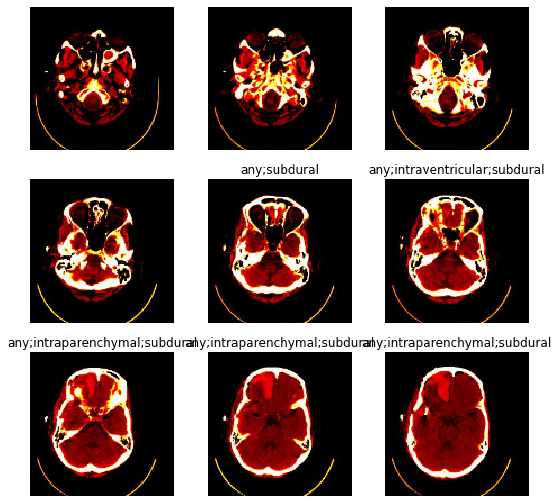

In [11]:
dls.valid.show_batch()

## Albumentations

In [12]:
#export
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

def get_cv2_fn(p):
    def _f(fn): 
        image = cv2.imread(str(p/f'{fn}.jpg'))
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return _f

import albumentations as ab
def ab_tfms(image_size):
    return ab.Compose([
        ab.Resize(*image_size),
        ab.HorizontalFlip(),
        ab.OneOf([
            ab.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            ab.GridDistortion(),
            ab.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
        ab.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10),
    ])

def ab_tfms_2nd(image_size):
    return ab.Compose([
        ab.HorizontalFlip(p=0.5),
        ab.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                             rotate_limit=20, p=0.3, border_mode = cv2.BORDER_REPLICATE),
        ab.Transpose(p=0.5)
    ])

def autocrop(image, threshold=0):
    """Crops any edges below or equal to threshold
    Crops blank image to 1x1.
    Returns cropped image.
    https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv
    """

    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    cols = np.where(np.max(flatImage, 1) > threshold)[0]
    image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    #logger.info(image.shape)
    sqside = max(image.shape)
    imageout = np.zeros((sqside, sqside, 3), dtype = 'uint8')
    imageout[:image.shape[0], :image.shape[1],:] = image.copy()
    return imageout

def autocropmin(image, threshold=0, kernel_size = 10):
        
    img = image.copy()
    SIZE = img.shape[0]
    imgfilt = ndimage.minimum_filter(img.max((2)), size=kernsel_size)
    rows = np.where(np.max(imgfilt, 0) > threshold)[0]
    cols = np.where(np.max(imgfilt, 1) > threshold)[0]
    row1, row2 = rows[0], rows[-1] + 1
    col1, col2 = cols[0], cols[-1] + 1
    row1, col1 = max(0, row1-kernsel_size), max(0, col1-kernsel_size)
    row2, col2 = min(SIZE, row2+kernsel_size), min(SIZE, col2+kernsel_size)
    image = image[col1: col2, row1: row2]
    #logger.info(image.shape)
    sqside = max(image.shape)
    imageout = np.zeros((sqside, sqside, 3), dtype = 'uint8')
    imageout[:image.shape[0], :image.shape[1],:] = image.copy()
    return imageout


def autocrop_tfm(img):
    if img.mean() == 0: return img
    try: img = autocrop(img, threshold=0, kernel_size = image.shape[0]//15)
    except: img = autocrop(img, threshold=0)  
    return img

class ABTfms(Transform):
    "Randomly flip with probability `p`"
    def __init__(self, image_size, autocrop=False): 
        super().__init__()
        self.tfms = ab_tfms(image_size)
        self.valid_tfm = ab.Resize(*image_size)
        self.autocrop = autocrop
    
    def __call__(self, b, split_idx=None, **kwargs):
        self.current_split = split_idx
        return super().__call__(b, split_idx=split_idx, **kwargs)
        
    def encodes(self, x, split_idx=None): 
        if self.autocrop: x = autocrop_tfm(x)
        if self.current_split == 1: return TensorImage(self.valid_tfm(image=x)['image'])
        return TensorImage(self.tfms(image=x)['image'])

In [13]:
# img_dir = 'nocrop_jpg256'
# img_tfm = get_cv2_fn(path/img_dir)
# tfms = [[img_tfm, ABTfms((128,128)), image2tensor], [fn2label,EncodedMultiCategorize(htypes)]]
# # tfms = [[img_tfm, ToTensor], [fn2label,EncodedMultiCategorize(htypes)]]
# fns = L(list(Meta.df_comb.index))
# dsets = Datasets(fns, tfms, splits=Meta.splits_stg1)



# dsets[0][0].max()

In [14]:
#export
def get_album_data_gen(fns, bs, img_tfm, splits, sz=None, nw=8, mean=mean, std=std, test=False, autocrop=False, **kwargs):
    tfms = [[img_tfm, ABTfms((sz,sz), autocrop), image2tensor], [fn2label,EncodedMultiCategorize(htypes)]]
    if test: tfms = [tfms[0]]
    dsets = Datasets(fns, tfms, splits=splits)
    nrm = Normalize.from_stats(mean,std)
    batch_tfms = L(IntToFloatTensor, nrm)
    return dsets.dataloaders(bs=bs, num_workers=nw, after_batch=batch_tfms)


In [15]:
#export
def get_album_data(bs, sz, splits, img_dir=path_jpg256, autocrop=False, **kwargs):
    return get_album_data_gen(L(list(Meta.df_comb.index)), bs=bs, img_tfm=get_cv2_fn(path/img_dir), 
                        sz=sz, splits=splits, autocrop=autocrop, **kwargs)

In [16]:
data_ab = get_album_data(512, 384, Meta.splits_sample, autocrop=True)

In [17]:
xb,yb = data_ab.one_batch()

## Training

In [18]:
#export
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()


def get_loss(scale=None):
    num_classes = 6
    loss_weights = to_device(tensor(2.0, 1, 1, 1, 1, 1))
    loss_weights = loss_weights/loss_weights.sum()*num_classes
    
    if scale is not None: scale = to_device(tensor([scale]*num_classes))
    return BaseLoss(nn.BCEWithLogitsLoss, weight=loss_weights, #pos_weight=scale,
                    floatify=True, flatten=False, is_2d=False, activation=torch.sigmoid)


In [19]:
#export
def get_learner(dls, arch_or_model, lf=None, pretrained=False, opt_func=None, metrics=None, fp16=True, config=None, name=None):
    if lf is None: lf = get_loss()
    if metrics is None: metrics=[accuracy_multi,accuracy_any]
    if opt_func is None: opt_func = partial(Adam, wd=1e-5, eps=1e-4, sqr_mom=0.999)
    if isinstance(arch_or_model, nn.Module):
        learn = Learner(dls, arch_or_model, loss_func=lf, lr=3e-3,
                    opt_func=opt_func, metrics=metrics)
    else:
        if config is None: config=dict(ps=0., lin_ftrs=[], concat_pool=False)
        learn = cnn_learner(dls, arch_or_model, pretrained=pretrained, loss_func=lf, lr=3e-3,
                            opt_func=opt_func, metrics=metrics, config=config)
    if name: learn.add_cb(SaveModelCallback(fname=name))
    return learn.to_fp16() if fp16 else learn

In [20]:
#export
moms=(0.9,0.9,0.9)
no_1cycle = dict(div=1, div_final=1, pct_start=0.1, moms=moms)

def do_fit(learn, epochs, lr, freeze=False, do_slice=False, **kwargs):
    if do_slice: lr = slice(lr*3,lr)
    if freeze:
        learn.freeze()
        learn.fit_one_cycle(1, lr, div=2, div_final=1, pct_start=0.1)
    learn.unfreeze()
    learn.fit_one_cycle(epochs, lr, **kwargs)

## Example

In [25]:
name = 'sample'

In [26]:
dls = get_data(512, 128, splits=Meta.splits_sample)
learn = get_learner(dls, xresnet18)

In [27]:
do_fit(learn, 1, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.682239,0.423794,0.864714,0.780036,00:16


In [28]:
learn.load(f'runs/{name}-1')

## Submission

In [21]:
#export
def get_test_data(df_tst, bs=512, sz=256, tst_dir='tst_jpg', sl=None):
    tst_fns = df_tst.index.values
    if sl is not None: tst_fns = tst_fns[sl]
    tst_splits = [L.range(tst_fns), L.range(tst_fns)]
    tst_dls = get_data_gen(tst_fns, bs=bs, img_tfm=get_pil_fn(path/tst_dir), sz=sz, splits=tst_splits, test=True)
    tst_dls.c = 6
    return tst_dls

In [22]:
#export
def submission(df_tst, preds, fn='submission'):
    ids,labels = [],[]
    for idx,pred in zip(df_tst.index, preds):
        for i,label in enumerate(htypes):
            ids.append(f"{idx}_{label}")
            labels.append('{0:1.10f}'.format(pred[i].item()))
    df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
    df_csv.to_csv(f'{fn}.csv', index=False)
    return df_csv

## Example Submission

In [33]:
learn.dls = get_test_data(Meta.df_tst, bs=256, sz=256)

In [34]:
# tst = test_dl(learn.dls, tst_fns, after_item=[get_pil_fn(path/'tst_jpg'), ToTensor])
# tst.tfms = Pipeline(funcs=[get_pil_fn(path/'tst_jpg'), ToTensor])

In [35]:
sub_fn = f'subm/{name}'

In [36]:
preds,targs = learn.get_preds()

In [38]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [39]:
FileLink(f'{sub_fn}.csv')

/home/ashaw/kaggle/rsna_retro/subm/sample.csv

In [7]:
api.competition_submit(f'{sub_fn}.csv', 'testing rsna_retro submission', 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:03<00:00, 8.99MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [15]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 13695014,
 'totalBytes': 27277209,
 'date': '2019-12-08T22:49:07.013Z',
 'description': 'testing rsna_retro submission',
 'errorDescription': None,
 'fileName': 'test_sub.csv',
 'publicScore': '0.95475',
 'privateScore': '0.06444',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/13695014/13695014.raw'}

## Save Predictions

In [23]:
#export
class DummyLoss:
    def __call__(self, p, *t, **kwargs): return torch.tensor(0, device=p.device).float()

In [24]:
#export
def save_features(learn, feat_path):
    preds,targs = learn.get_preds(dl=learn.dls.valid)
    val_ids = learn.dls.valid.dataset.items
    feat_path.mkdir(exist_ok=True)
    for idx,pred in progress_bar(zip(val_ids, preds), total=len(val_ids)):
        np.save(str(feat_path/f'{idx}'), pred.squeeze().numpy().astype(np.float16))

In [25]:
fn_save = 'runs/baseline_stg1_xresnet18-3'

In [26]:
#export
path_feat_384avg = path/'features_384_avg'
path_feat_tst_384avg = path/'tst_features_384_avg'

Comparison of datatypes:  
* No 7x7 - 34G
* 7x7 - 18G
* 7x7 float16 - 6.1G

In [27]:
dls = get_test_data(Meta.df_tst, bs=256, sz=384, tst_dir='tst_jpg')
learn = get_learner(dls, xresnet18, lf=DummyLoss(), metrics=[])
learn.load(fn_save)
learn.model = nn.Sequential(learn.model[0], nn.AdaptiveAvgPool2d((8,8)))
save_features(learn, path_feat_tst_384avg)

In [28]:
dls = get_test_data(Meta.df_comb, bs=128, sz=384, tst_dir='nocrop_jpg')
learn = get_learner(dls, xresnet18, lf=DummyLoss(), metrics=[])
learn.load(fn_save)
learn.model = nn.Sequential(learn.model[0], nn.AdaptiveAvgPool2d((8,8)))
save_features(learn, path_feat_384avg)

## Export

In [4]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 03_train3d.ipynb.
Converted 03_train3d_01_train3d.ipynb.
Converted 03_train3d_01b_train_lstm.ipynb.
Converted 03_train3d_02_train_3d_head.ipynb.
Converted 03_train3d_02_train_lstm_head.ipynb.
Converted 03_trainfull3d.ipynb.
Converted 04_trainSeq_01_lstm.ipynb.
Converted 04_trainSeq_02_transformer.ipynb.
Converted 04_trainSeq_03_lstm_seutao.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 05_train_adjacent_01_5c_windowed.ipynb.
Converted 05_train_adjacent_01_5slice.ipynb.
Converted 05_train_adjacent_02_3c.ipynb.
Converted 05_train_adjacent_02_3c_stg1.ipynb.
Converted 06_seutao_features.ipynb.
Converted 06_seutao_features_01_simple_lstm_20ep.ipynb.
Converted 06_seutao_features_01b_simple_lstm_10ep.ipynb.
Converted 06_seutao_features_01c_simple_lstm_meta.ipynb.
Converted 06_seutao_features_01d_simple_lstm_meta_full.ipynb.
Converted 06_seutao_features_0